
# Trajectoires de tempêtes dans les réanalyses ERA5

Calepin à utiliser pour le tracé de trajectoires de tempêtes remarquables à partir des fichiers "tempête.txt" obtenus grâce au programme de tracking automatique du calepin "ERA5_storms_tracking_auto.ipynb".

In [51]:
import os

import xarray as xr
import netCDF4

import numpy as np

from cartopy import config
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

from tqdm import tqdm

In [11]:
storms=['Nov1982', 'Oct1987', 'Herta', 'Viviane', 'Lothar', 'Martin', 'Klaus', 'Xynthia',
        'Joachim', 'Zeus', 'Ophelia', 'Eleanor', 'Alex', 'Ciaran','Braer']

<div class="alert alert-danger">
<p><b>Vérifier que les trajectoires des tempêtes tracées à partir du programme de tracking automatique sont correctes.</b></p>
</div>

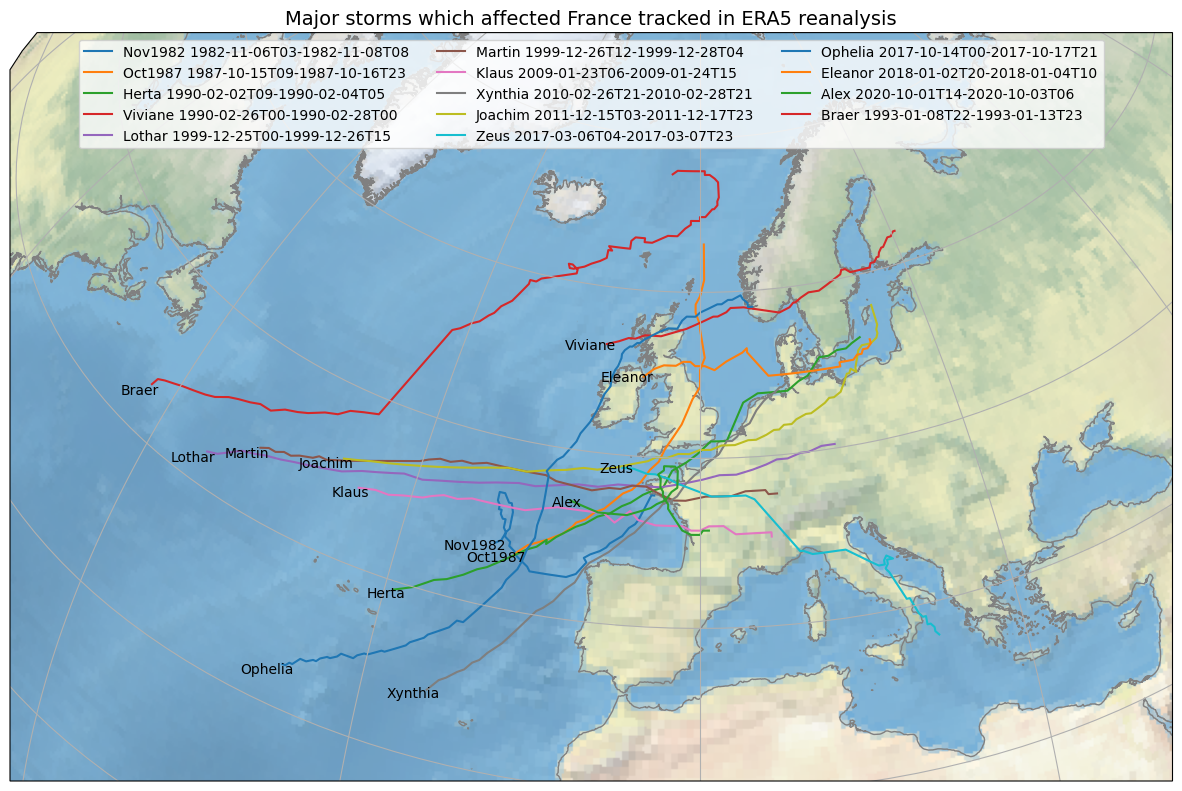

In [55]:
projection=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=45.0)
bounds = [(-60, 35, 30, 70)]
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline')
                             
fig = plt.figure(figsize=(15., 10.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Major storms which affected France tracked in ERA5 reanalysis',loc='center',fontsize=14)
ax.add_feature(coast, edgecolor='gray')
ax.gridlines()
ax.stock_img()

ax.set_extent(*bounds, crs=ccrs.PlateCarree())

for storm in storms:
    liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',skiprows=0, dtype='U13,float,float,int',unpack=True)
    date1=str(liste_time[0])
    date2=str(liste_time[-1])
    ax.plot(liste_lon,liste_lat, transform=ccrs.PlateCarree(), label=storm+' '+date1+'-'+date2)
    ax.text(liste_lon[0]+1, liste_lat[0], storm, verticalalignment='center', horizontalalignment='right',transform=ccrs.PlateCarree())

ax.legend(loc="upper center", ncol=3)
plt.show()

figname='./figs/tracks'
fig.savefig(figname+'.png')

In [13]:
interval=int(input("Enter the desired time interval : "))

if not os.path.exists("./figs/tracking"):
    os.makedirs("./figs/tracking")

Enter the desired time interval : 3


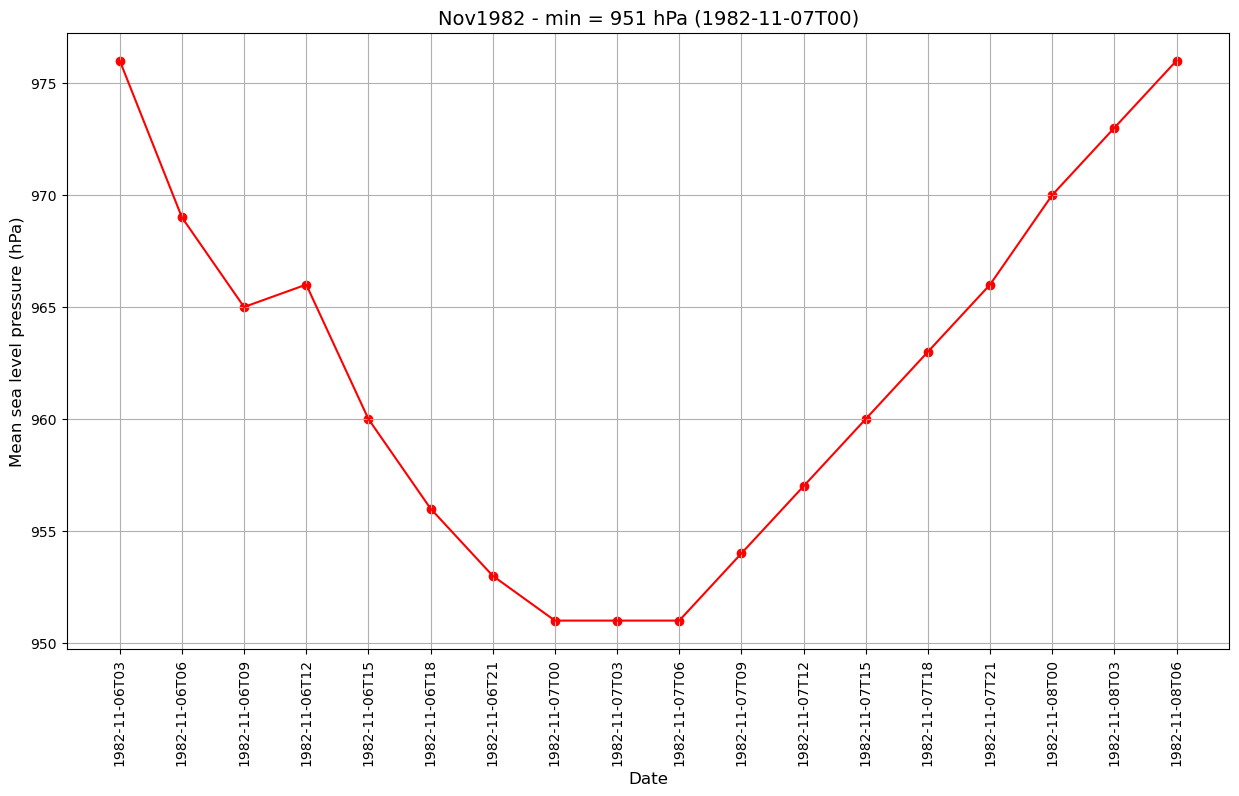

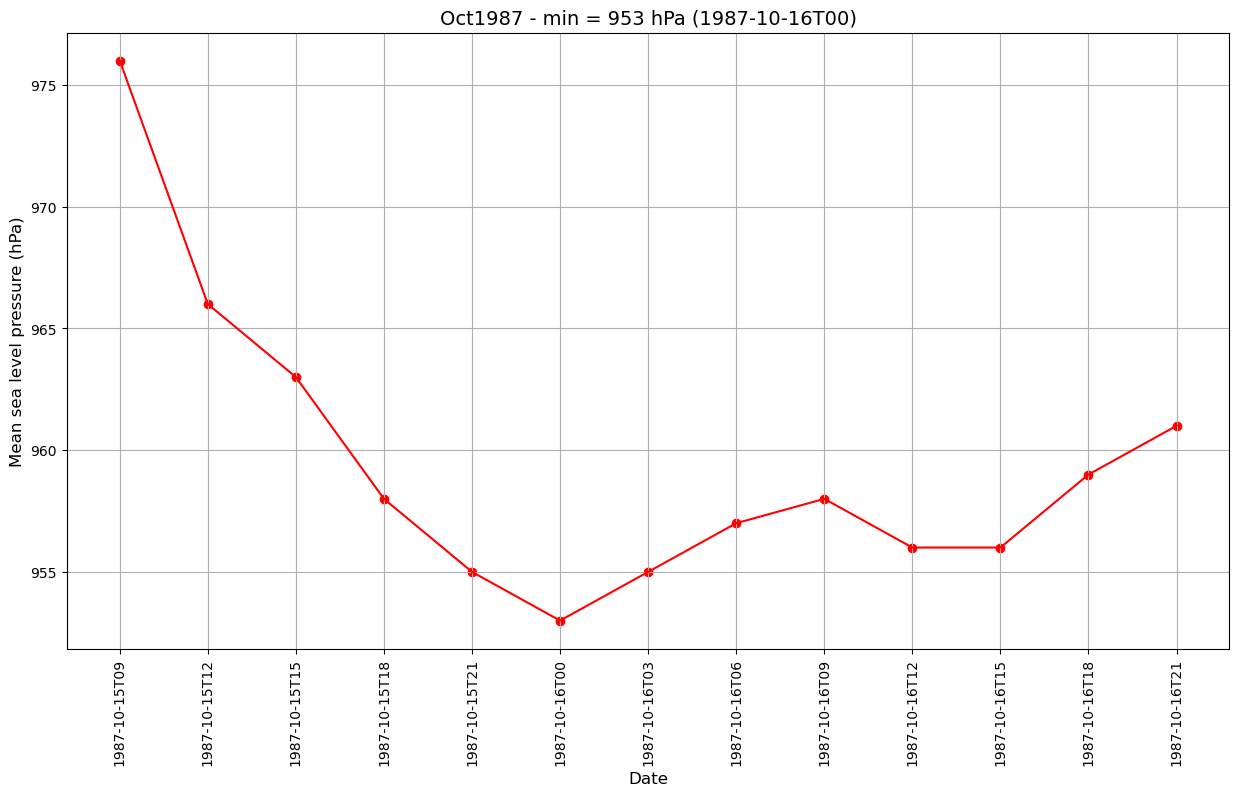

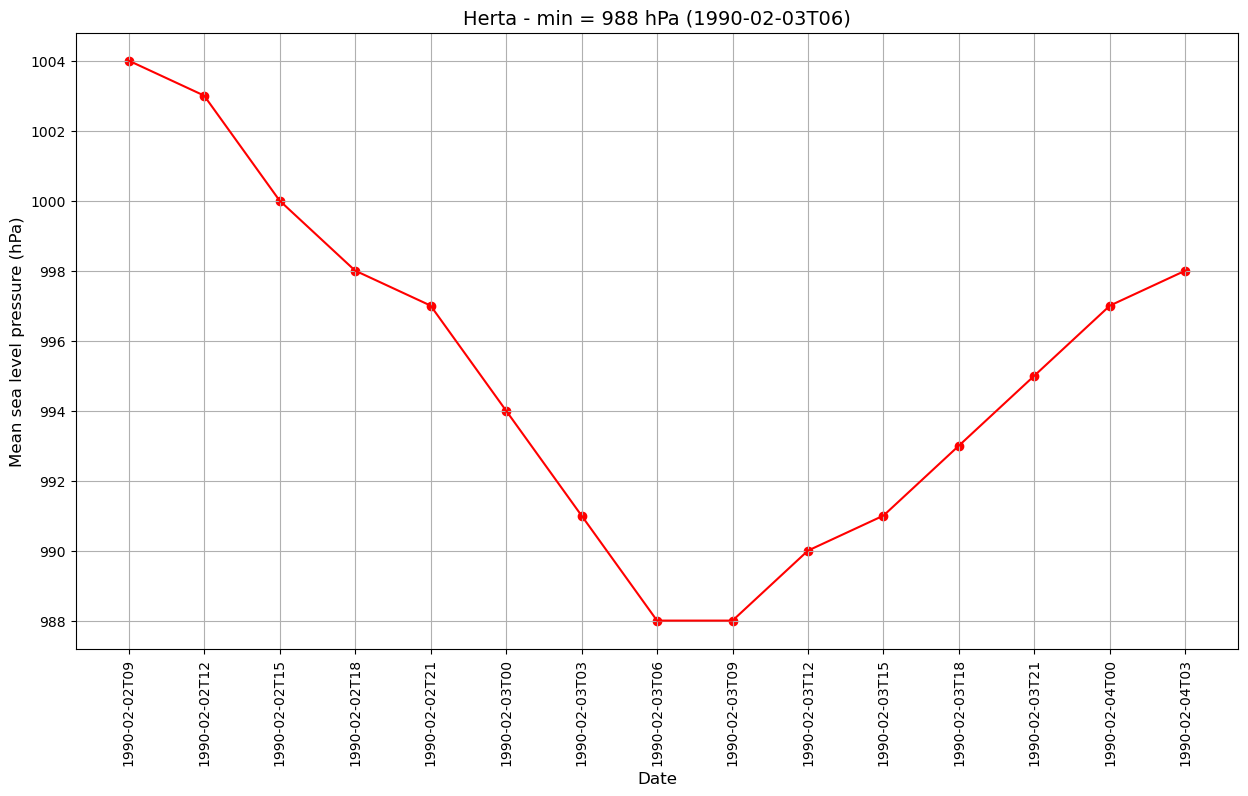

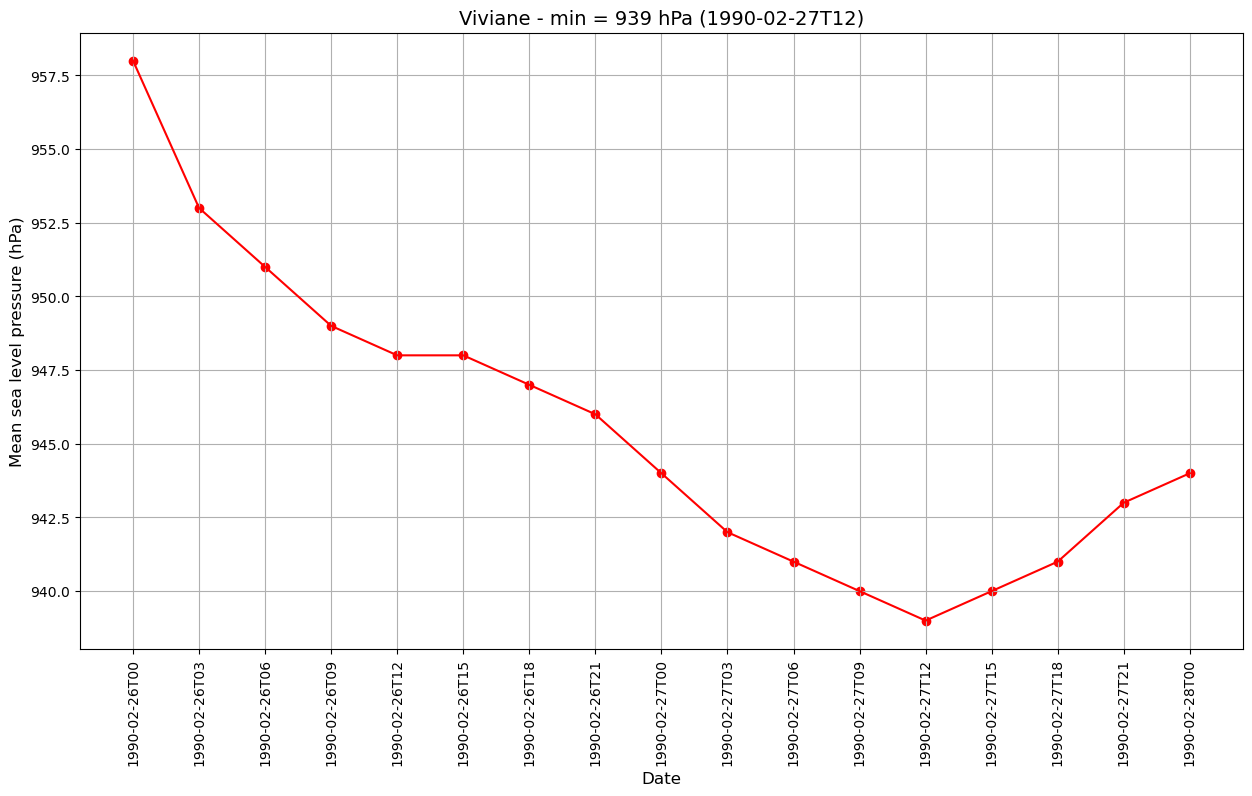

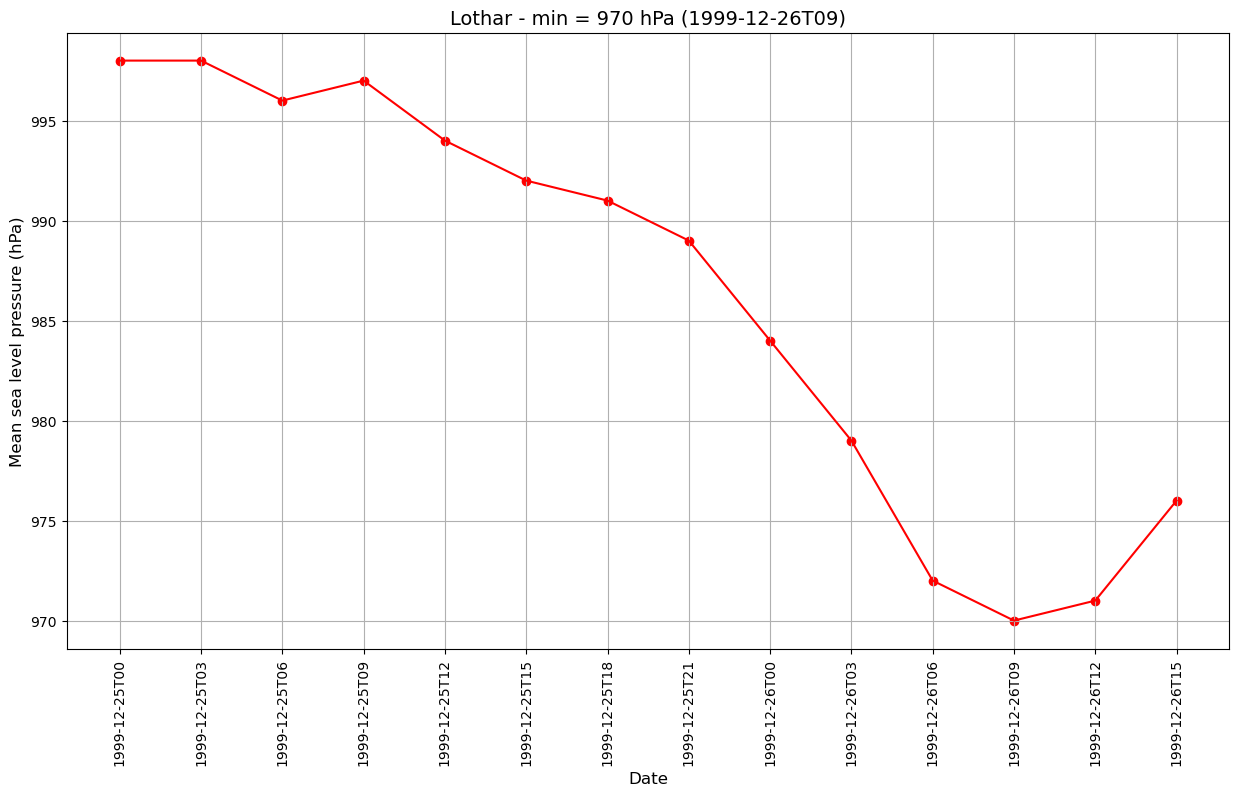

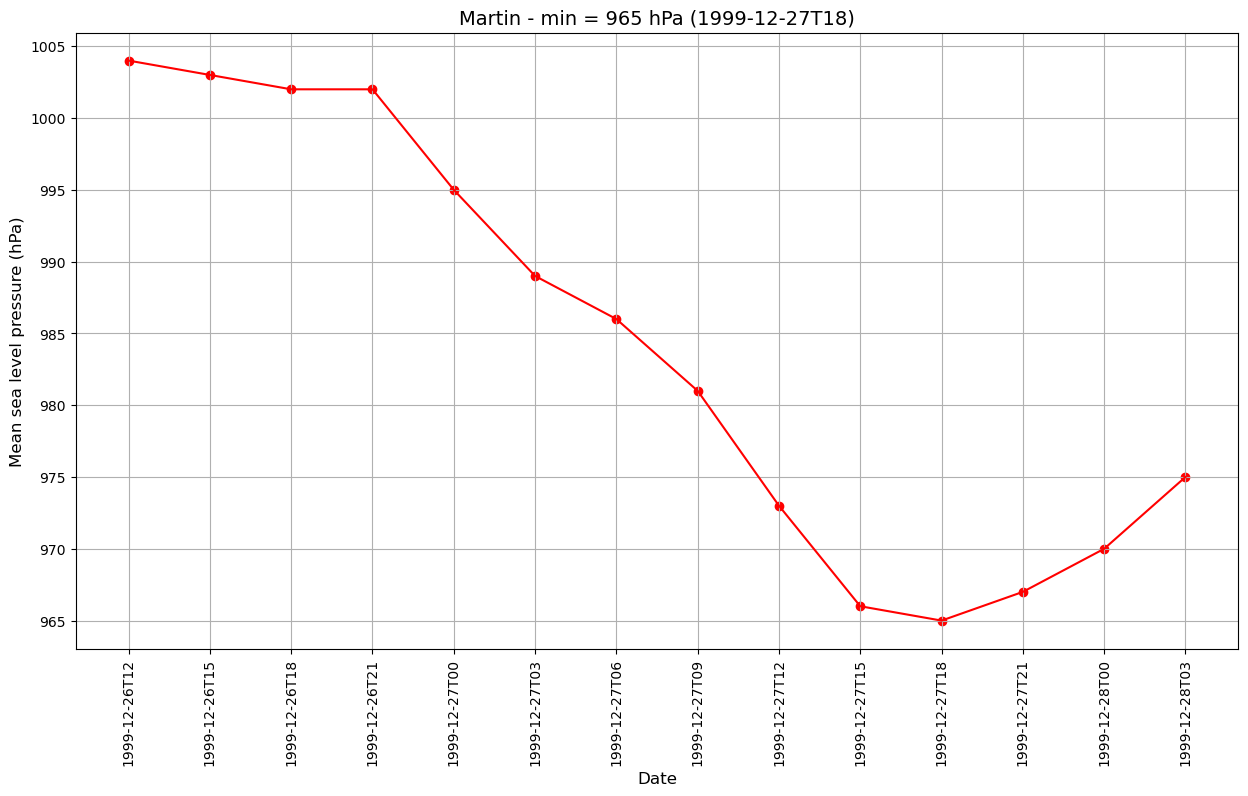

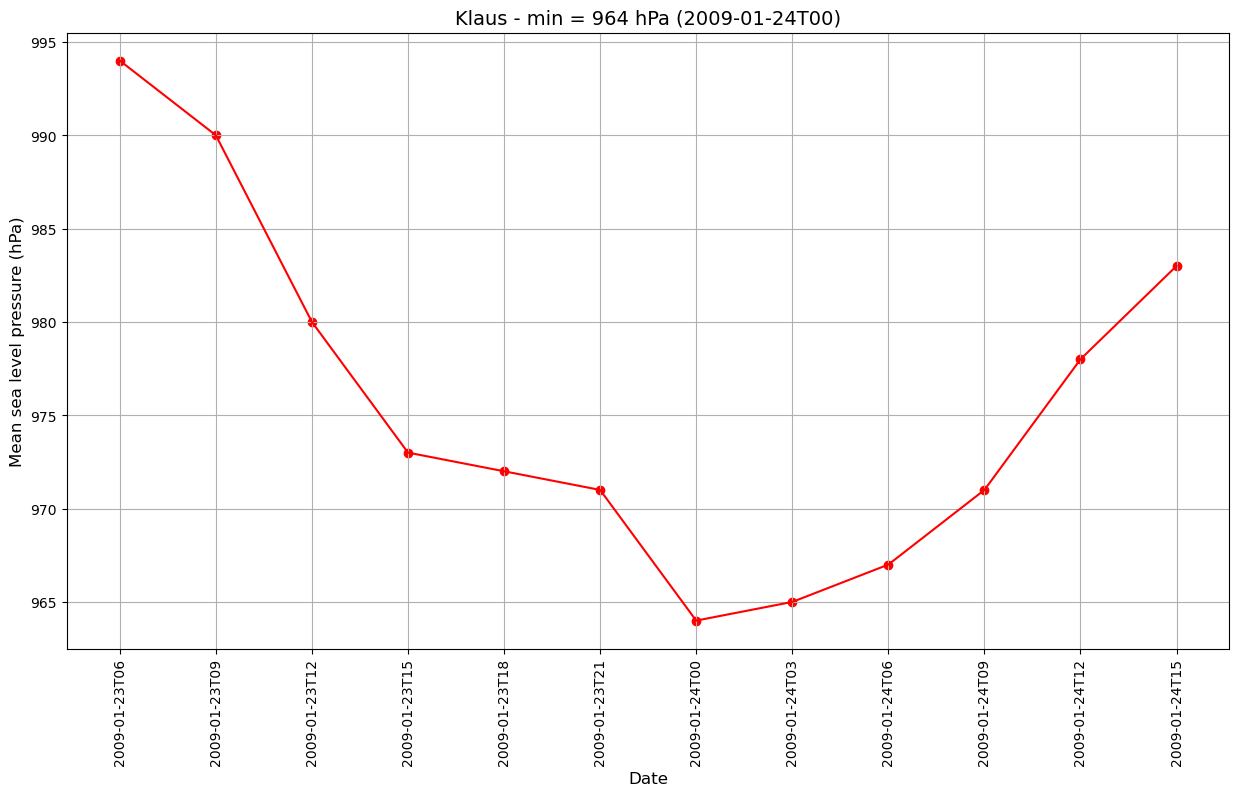

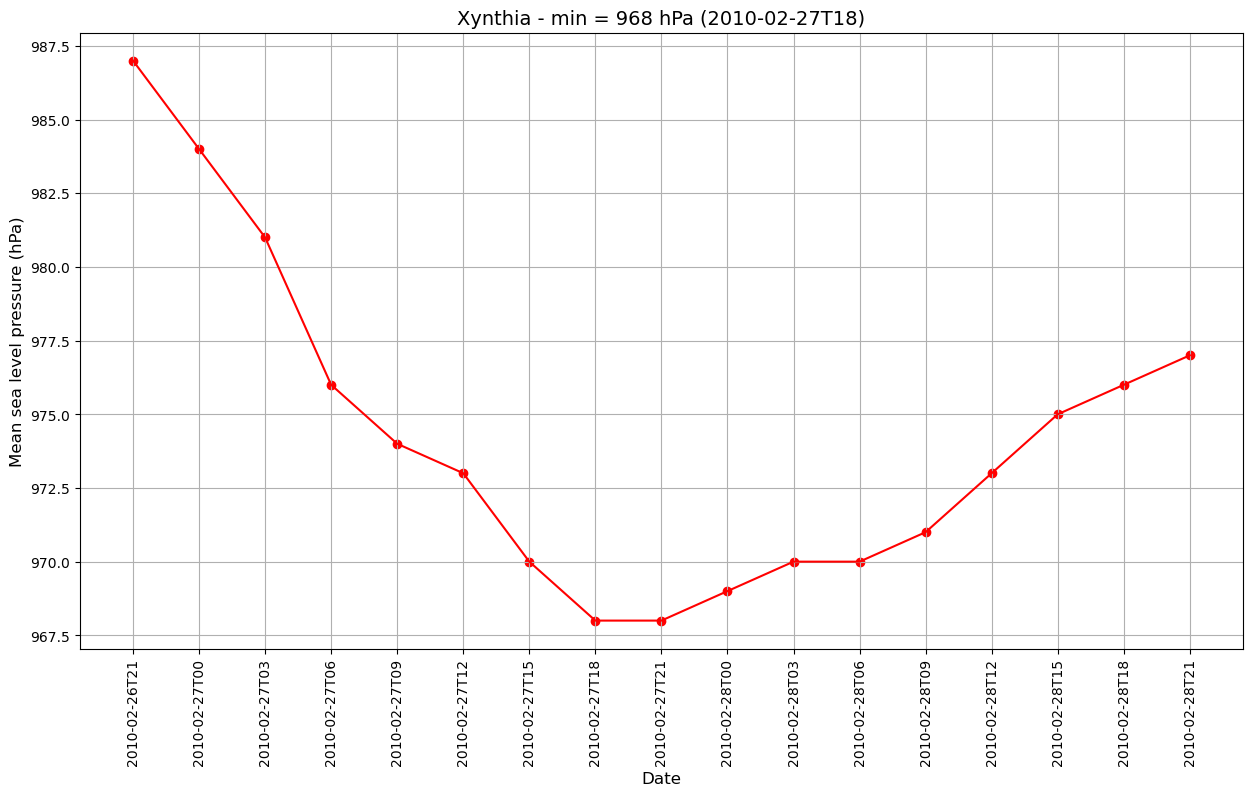

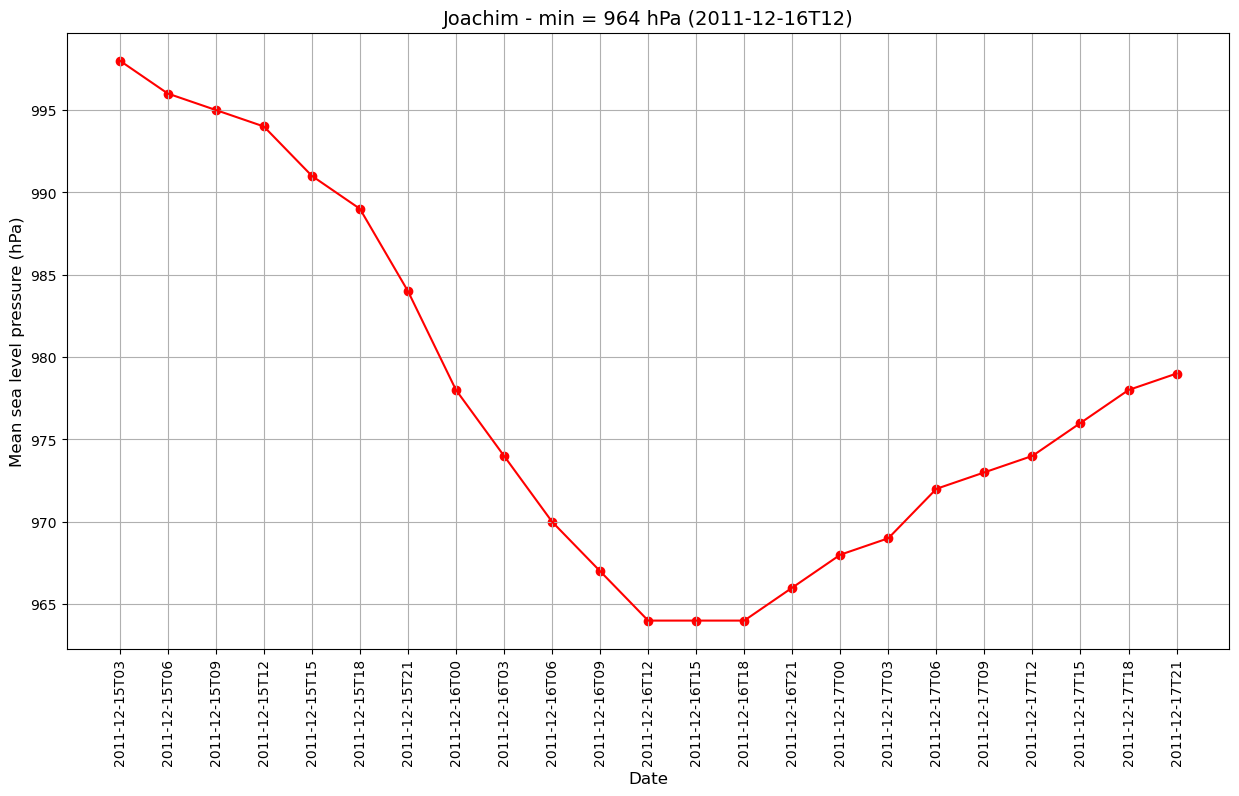

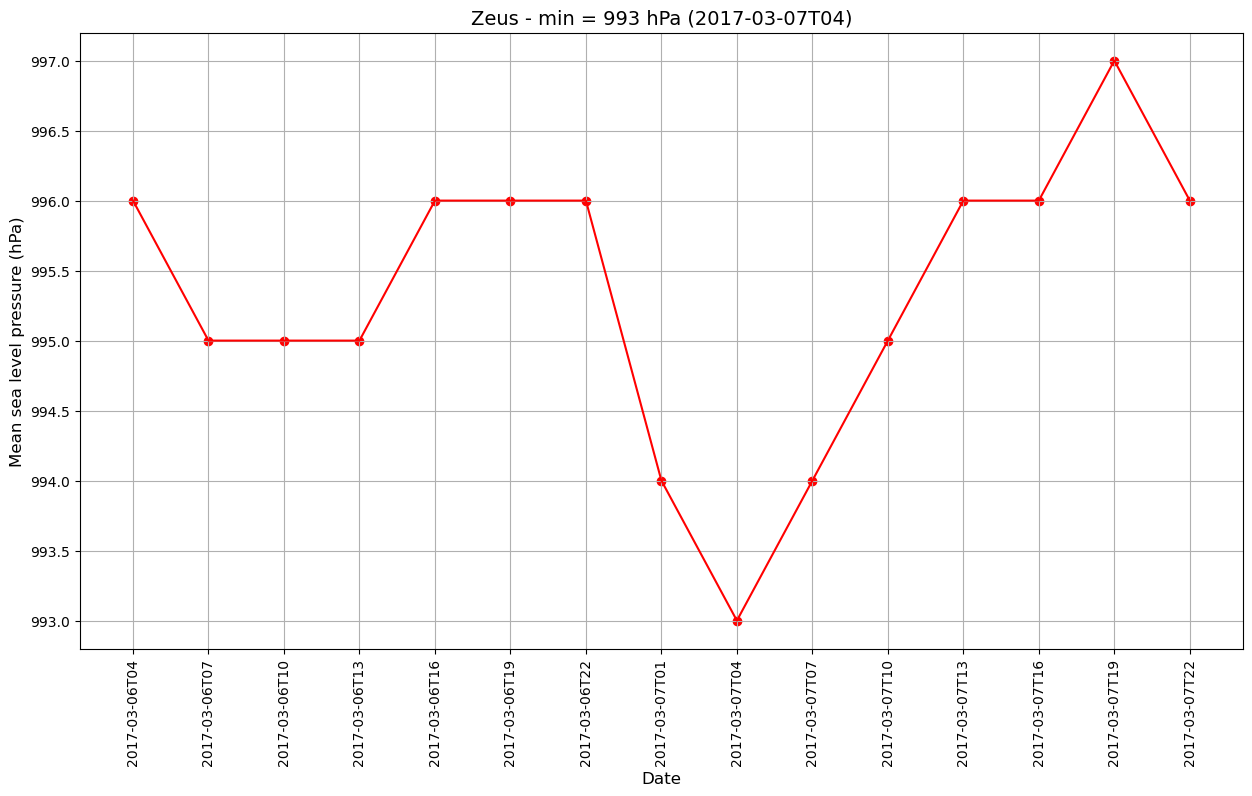

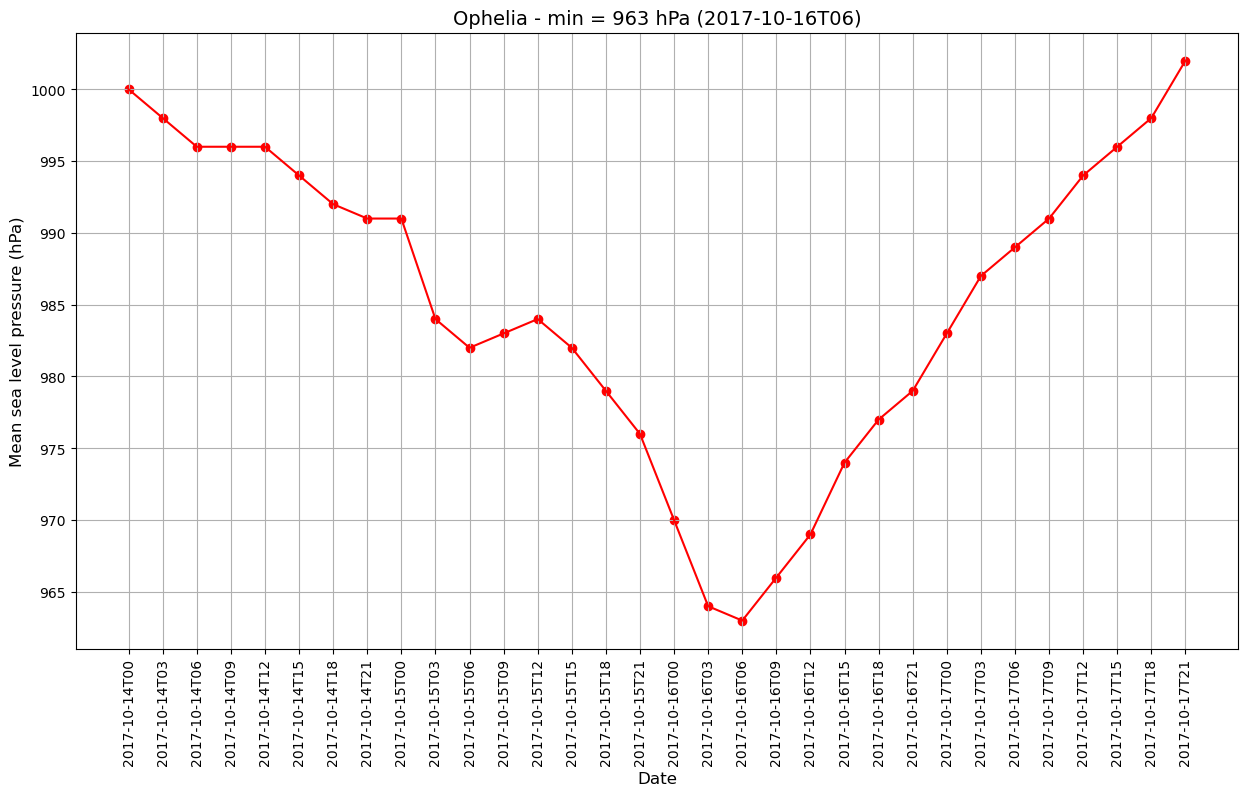

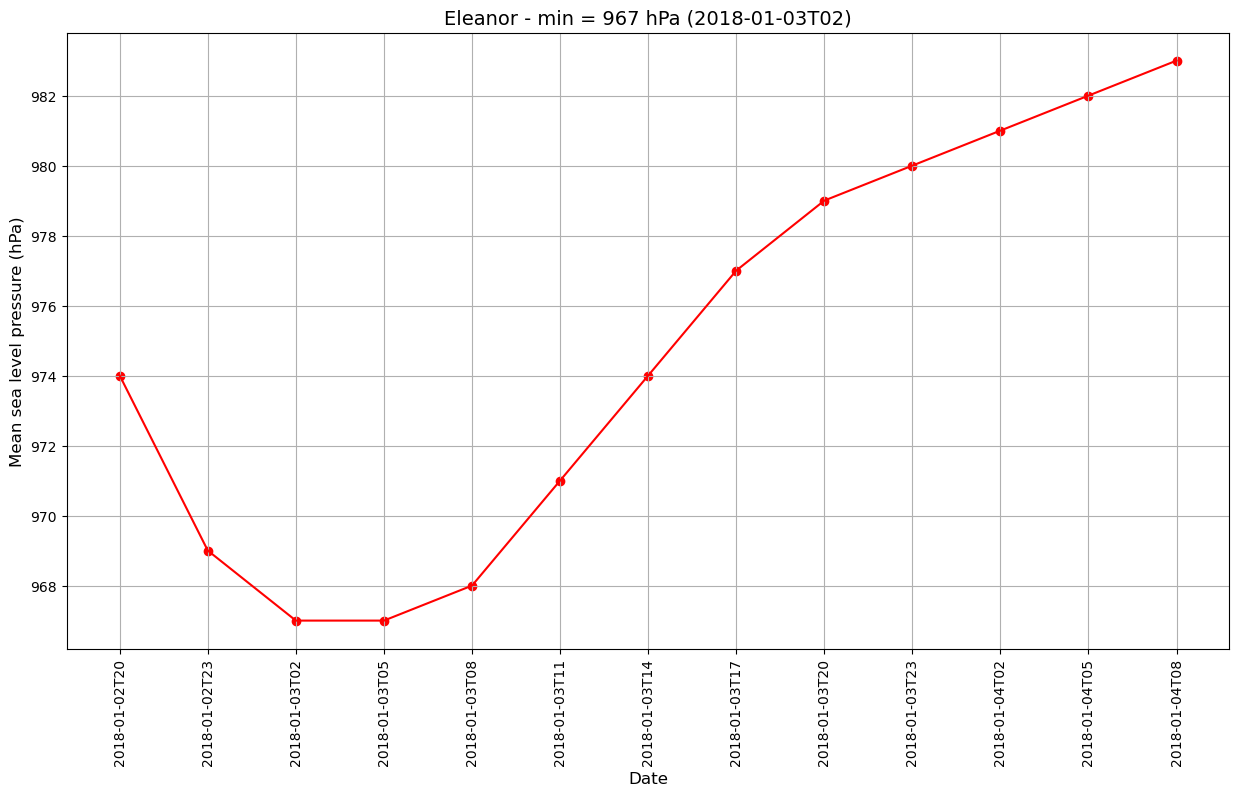

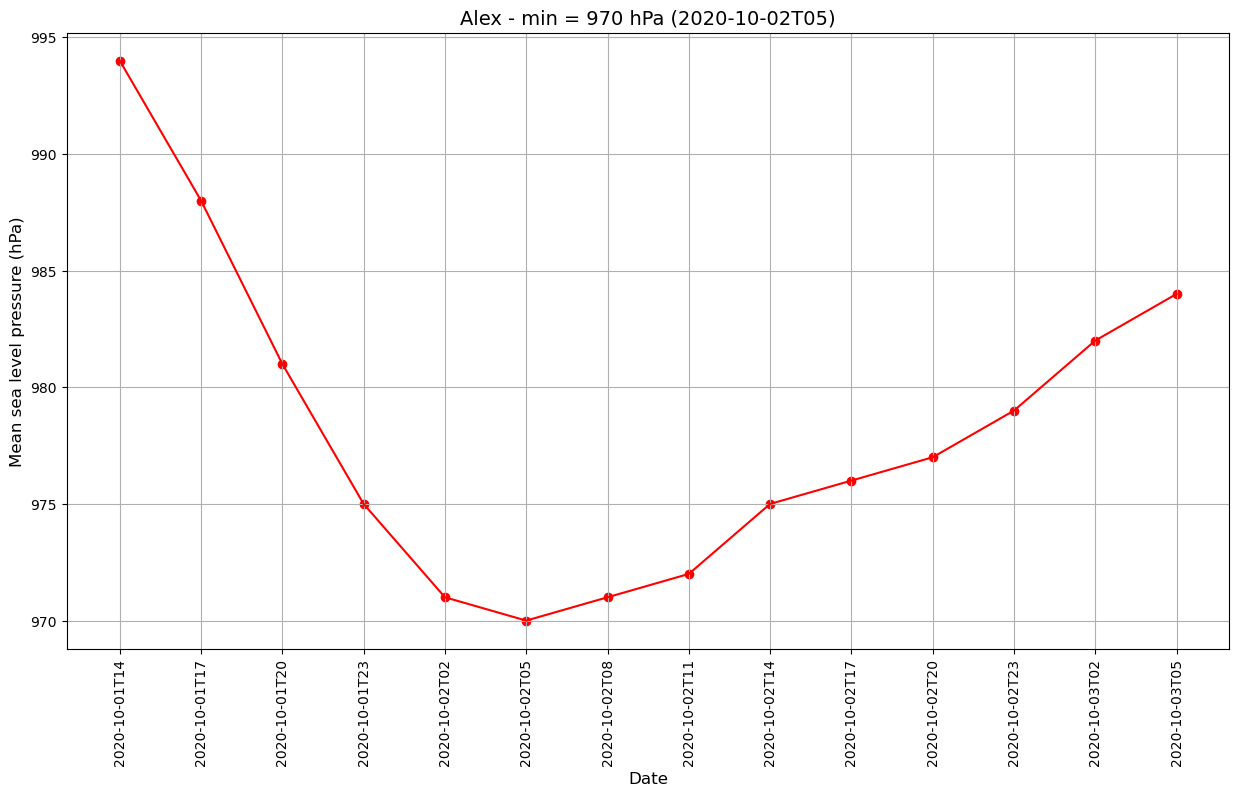

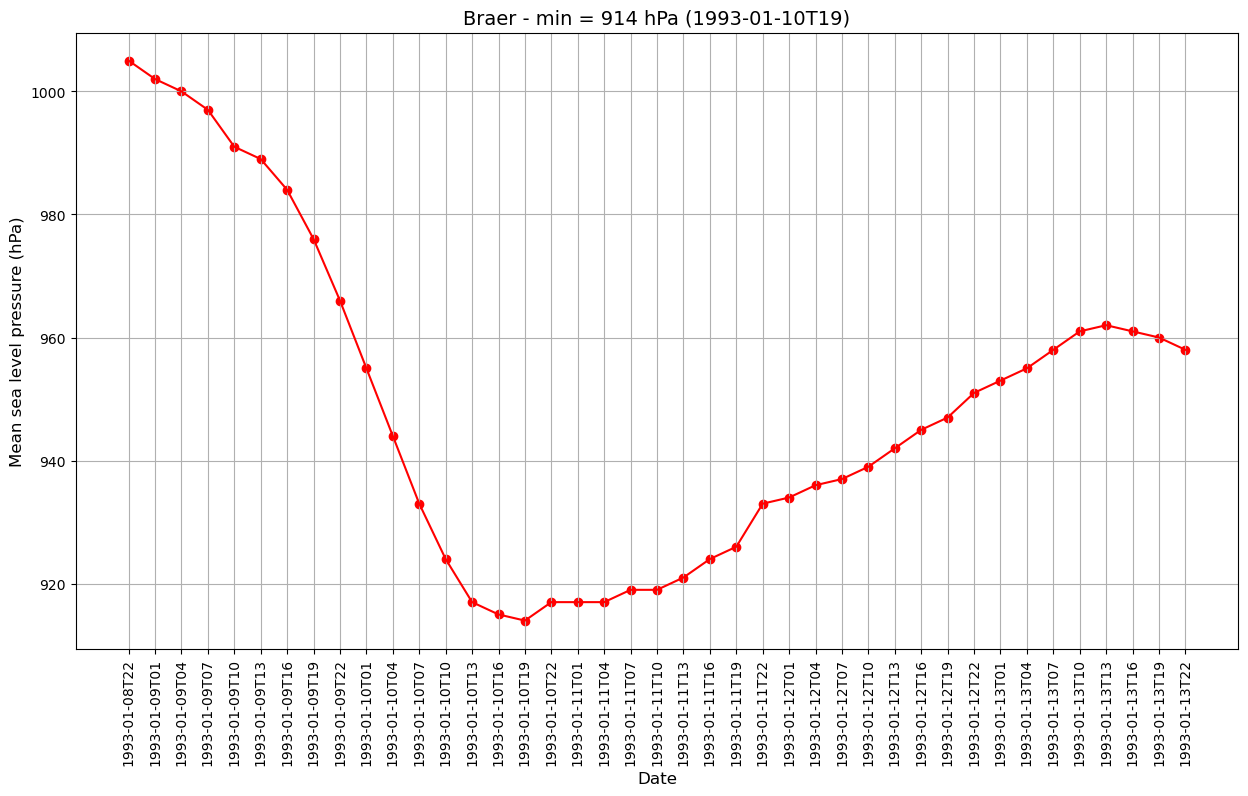

In [14]:
for storm in storms:
    
    liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',skiprows=0,
                                                         dtype='U13,float,float,int',unpack=True)

    liste_time=liste_time[::interval]
    liste_lon=liste_lon[::interval]
    liste_lat=liste_lat[::interval]
    liste_pres=liste_pres[::interval]
    date1=str(liste_time[0])
    date2=str(liste_time[-1])

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(storm+' - min = '+str(np.min(liste_pres))+' hPa ('+str(liste_time[np.argmin(liste_pres)])+')',
                 loc='center',fontsize=14)
    ax.plot(liste_time,liste_pres, color='red', label=storm)
    ax.scatter(liste_time,liste_pres, color='red')
    plt.grid()
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Mean sea level pressure (hPa)', fontsize=12)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    ax.tick_params(axis='x', labelsize=10)
    plt.show()
    figname='./figs/tracking/'+storm+'_slp_evolution'
    fig.savefig(figname+'.png')

<div class="alert alert-danger">
<p><b>
Pour chaque tempête, calculer la baisse de pression maximale et préciser la période concernée par cette baisse.

Indication : s'aider de la fonction calculer_baisse_maximale_pression et de l'exemple proposé.</b></p>

</div>

In [45]:
def calculer_baisse_maximale_pression(pressions):
    pression_min = float('inf')
    pression_max = float('-inf')
    debut_baisse_max = 0
    fin_baisse_max = 0
    points_baisse_max = 0
    points_actuels = 0

    for i, pression in enumerate(pressions):
        if pression > pression_max:
            pression_max = pression
            points_actuels = 0
        if pression < pression_min:
            pression_min = pression
            points_actuels += 1
            if points_actuels > points_baisse_max:
                points_baisse_max = points_actuels
                debut_baisse_max = i - points_actuels + 1
                fin_baisse_max = i
        elif pression == pression_min:
            points_actuels += 1
        else:
            points_actuels = 0

    return pression_max - pression_min, points_baisse_max, debut_baisse_max, fin_baisse_max


ex_pres=[1005,1004,1002,1000,995,982,980,978,970,962,955,950]
baisse_maximale, points_baisse_max, debut_baisse_max, fin_baisse_max = calculer_baisse_maximale_pression(ex_pres)
print('baisse max (hPa) : ', baisse_maximale)
print('nb de points concernés par la baisse : ', points_baisse_max)
print('indice de début de la baisse dans tableau pressions : ', debut_baisse_max)
print('indice de fin de la baisse dans tableau pressions : ', fin_baisse_max)

baisse max (hPa) :  55
nb de points concernés par la baisse :  12
indice de début de la baisse dans tableau pressions :  0
indice de fin de la baisse dans tableau pressions :  11


In [16]:
for storm in storms:
    
    liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',skiprows=0,
                                                         dtype='U13,float,float,int',unpack=True)

    liste_time=liste_time[::interval]
    liste_lon=liste_lon[::interval]
    liste_lat=liste_lat[::interval]
    liste_pres=liste_pres[::interval]
    date1=str(liste_time[0])
    date2=str(liste_time[-1])
    
    # Maximum pressure fall
    baisse_maximale, points_baisse_max, debut_baisse_max, fin_baisse_max = calculer_baisse_maximale_pression(liste_pres)
    
    print('-------------------------------------------------------------------------------')
    print(storm)
    print("Maximum pressure fall (hPa) : ", baisse_maximale)
    print("Beginning of the deepening phase : ", liste_time[debut_baisse_max])
    print("End of the deepening phase : ", liste_time[fin_baisse_max])
    print("Number of elapsed hours during the maximum pressure fall : ", (points_baisse_max*interval)-interval)
    print("Corresponding mean pressure fall rate in hPa/h : ", round(baisse_maximale/(points_baisse_max*interval),2))

-------------------------------------------------------------------------------
Nov1982
Maximum pressure fall (hPa) :  25
Beginning of the deepening phase :  1982-11-06T15
End of the deepening phase :  1982-11-07T00
Number of elapsed hours during the maximum pressure fall :  9
Corresponding mean pressure fall rate in hPa/h :  2.08
-------------------------------------------------------------------------------
Oct1987
Maximum pressure fall (hPa) :  23
Beginning of the deepening phase :  1987-10-15T09
End of the deepening phase :  1987-10-16T00
Number of elapsed hours during the maximum pressure fall :  15
Corresponding mean pressure fall rate in hPa/h :  1.28
-------------------------------------------------------------------------------
Herta
Maximum pressure fall (hPa) :  16
Beginning of the deepening phase :  1990-02-02T09
End of the deepening phase :  1990-02-03T06
Number of elapsed hours during the maximum pressure fall :  21
Corresponding mean pressure fall rate in hPa/h :  0.67
-

<div class="alert alert-warning">
<p><b>
Sanders et Gyakum (1980) définissent une cyclogenèse explosive (CE) lorsque la pression centrale minimale chute de plus de 24 hPa en 24 h lorsqu'elle est ajustée géostrophiquement à 60°N (l'ajustement de la latitude est effectué pour tenir compte de la variation du vent géostrophique avec la latitude pour un gradient de pression donné). Comme les CE se produisent généralement aux latitudes moyennes et que les données de réanalyse à haute résolution sont largement utilisées, Zhang et al. (2017) ont ajusté la latitude à 45°N et fixé la chute de pression à 12 hPa/12 h. Selon cette définition, le taux de creusement (en Bergeron) d'un cyclone au temps t est défini comme :
$$DR(t) = \frac{sin(45°)}{sin(\phi(t))} ) * \frac{P_{t-6h}-P_{t+6h}}{12h}$$
    
Selon le taux de creusement maximal Zhang et al. (2017) ont classifié le CE en 4 catégories : Super (≥2.30 Bergeron), forte (1.70–2.29 Bergeron), modérée (1.30–1.69 Bergeron) et faible (1.00–1.29 Bergeron).</b></p>
</div>

<div class="alert alert-danger">
<p><b>
Pour chaque tempête, calculer le taux de creusement maximal en Bergeron selon la définition de Zhang et al. et préciser la date où ce creusement maximal a lieu.
    
Indication : s'aider de la fonction running_diff et des exemples fictifs proposés avec des séries temporelles 6h ou 3h.</b></p>
</div>

In [47]:
def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

ex_time=['2020-10-02T00','2020-10-02T06','2020-10-02T12','2020-10-02T18','2020-10-03T00','2020-10-03T06',
     '2020-10-03T12','2020-10-03T18','2020-10-04T00','2020-10-04T06','2020-10-04T12','2020-10-04T18']
ex_pres=[1005,1004,1002,1000,995,982,980,978,970,962,955,950]

N=2 #12h in time array
diff=running_diff(ex_pres, N)
max_dr=np.min(diff)
max_dr_ind=np.argmin(diff)
print(ex_time)
print(ex_pres)
print(diff)
print('baisse max 12h : ', max_dr)
print('indice baisse max dans tableau diff : ', max_dr_ind)
print('date baisse max : ', ex_time[max_dr_ind+int(N/2)])


print('************************')

ex_time=['2020-10-02T00','2020-10-02T03','2020-10-02T06','2020-10-02T09','2020-10-02T12','2020-10-02T15',
     '2020-10-02T18','2020-10-03T00','2020-10-03T03','2020-10-03T06','2020-10-03T09','2020-10-03T12']
ex_pres=[1005,1004,1002,1000,995,982,980,978,970,962,955,950]

N=4 #12h in time array
diff=running_diff(ex_pres, N)
max_dr=np.min(diff)
max_dr_ind=np.argmin(diff)
print(ex_time)
print(ex_pres)
print(diff)
print('baisse max 12h : ', max_dr)
print('indice baisse max dans tableau diff : ', max_dr_ind)
print('date baisse max : ', ex_time[max_dr_ind+int(N/2)])

['2020-10-02T00', '2020-10-02T06', '2020-10-02T12', '2020-10-02T18', '2020-10-03T00', '2020-10-03T06', '2020-10-03T12', '2020-10-03T18', '2020-10-04T00', '2020-10-04T06', '2020-10-04T12', '2020-10-04T18']
[1005, 1004, 1002, 1000, 995, 982, 980, 978, 970, 962, 955, 950]
[ -3  -4  -7 -18 -15  -4 -10 -16 -15 -12]
baisse max 12h :  -18
indice baisse max dans tableau diff :  3
date baisse max :  2020-10-03T00
************************
['2020-10-02T00', '2020-10-02T03', '2020-10-02T06', '2020-10-02T09', '2020-10-02T12', '2020-10-02T15', '2020-10-02T18', '2020-10-03T00', '2020-10-03T03', '2020-10-03T06', '2020-10-03T09', '2020-10-03T12']
[1005, 1004, 1002, 1000, 995, 982, 980, 978, 970, 962, 955, 950]
[-10 -22 -22 -22 -25 -20 -25 -28]
baisse max 12h :  -28
indice baisse max dans tableau diff :  7
date baisse max :  2020-10-03T06


In [18]:
for storm in storms:
    
    liste_time,liste_lon,liste_lat,liste_pres=np.loadtxt('./txt/'+storm+'.txt',skiprows=0,
                                                         dtype='U13,float,float,int',unpack=True)

    liste_time=liste_time[::interval]
    liste_lon=liste_lon[::interval]
    liste_lat=liste_lat[::interval]
    liste_pres=liste_pres[::interval]
    date1=str(liste_time[0])
    date2=str(liste_time[-1])
    
    # 12h deepening rate
    N=int((12/interval))
    dr=running_diff(liste_pres, N)
    max_dr=np.min(dr)
    max_dr_ind=np.argmin(dr)
    max_dr_bergeron=-(max_dr/12)*np.sin(45*np.pi/180)/np.sin(liste_lat[max_dr_ind+int(N/2)]*np.pi/180)
    
    print('-------------------------------------------------------------------------------')
    print(storm)
    print('Maximum 12h instantaneus deepening rate at latitude '+str(liste_lat[max_dr_ind+int(N/2)])+' (hPa/12h) : '
          , round(-max_dr,2))
    print('Maximum instantaneus deepening rate (Bergeron) : ', round(max_dr_bergeron,2))
    print('Maximum instantaneus deepening rate date : ', liste_time[max_dr_ind+int(N/2)])

-------------------------------------------------------------------------------
Nov1982
Maximum 12h instantaneus deepening rate at latitude 46.25 (hPa/12h) :  16
Maximum instantaneus deepening rate (Bergeron) :  1.31
Maximum instantaneus deepening rate date :  1982-11-06T09
-------------------------------------------------------------------------------
Oct1987
Maximum 12h instantaneus deepening rate at latitude 45.5 (hPa/12h) :  21
Maximum instantaneus deepening rate (Bergeron) :  1.73
Maximum instantaneus deepening rate date :  1987-10-15T15
-------------------------------------------------------------------------------
Herta
Maximum 12h instantaneus deepening rate at latitude 44.75 (hPa/12h) :  10
Maximum instantaneus deepening rate (Bergeron) :  0.84
Maximum instantaneus deepening rate date :  1990-02-03T00
-------------------------------------------------------------------------------
Viviane
Maximum 12h instantaneus deepening rate at latitude 57.75 (hPa/12h) :  10
Maximum instanta